In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import matplotlib.animation as manimation
from matplotlib.colors import LogNorm

import copy

import numpy as np
import pickle
from tqdm import tqdm

In [2]:
dic = pickle.load(open('animation_box_gp_holdr.pkl', 'rb'))
maskedImage = dic['IN']

dic_current = pickle.load(open('data/out_test_0', 'rb'))
maskedImage_current_interp = dic_current['out']['maskedImage']

In [3]:
indexes = []
N = len(dic['OUT'].keys())
for i in tqdm(range(N)):
    if len(dic['OUT'][i]['GP'].keys()) != 0:
        #print(i)
        indexes.append(i)

100%|██████████| 5460/5460 [00:00<00:00, 2602374.98it/s]


In [6]:
def plot_rectangle(lim, ax=None):
    x_min, x_max = lim[0][0], lim[0][1]
    y_min, y_max = lim[1][0], lim[1][1]
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='y', facecolor='none')
    if ax is None:
        plt.gca().add_patch(rect)
    else:
        ax.add_patch(rect)

def get_sub_image(Image, lim):
    x_min, x_max = lim[0][0], lim[0][1]
    y_min, y_max = lim[1][0], lim[1][1]    
    return Image[x_min:x_max, y_min:y_max]


def setup_plot():
    fig = plt.figure(figsize=(20,12))
    gs = gridspec.GridSpec(3, 4)
    ax1 = plt.subplot(gs[:, :-2])
    ax2 = plt.subplot(gs[-3, -2])
    ax3 = plt.subplot(gs[-2, -2])
    ax4 = plt.subplot(gs[-1, -2])
    #ax5 = plt.subplot(gs[-1, -1])
    axes = [ax1, ax2, ax3, ax4]
    return fig, axes

def update(maskedImage, gp_interp, lim):
    x_min, x_max = lim[0][0], lim[0][1]
    y_min, y_max = lim[1][0], lim[1][1]
    maskedImage[x_min:x_max, y_min:y_max] = gp_interp
    

def get_plot(maskedImage, maskedImage_current_interp, I, dic, fig, axes, first_time=True, replace=False, log_scale = True):

    CMAP = plt.cm.Greys_r

    if not log_scale:
        kwargs = {'vmin': 400, 'vmax': 800}
    else:
        kwargs = {'norm': LogNorm(vmin=200, vmax=30000)}

    ax1 = axes[0]
    ax2 = axes[1]
    ax3 = axes[2]
    ax4 = axes[3]
    #ax5 = axes[4]

    im = ax1.imshow(maskedImage.getImage().array, cmap=CMAP, **kwargs)
    ax1.axis('equal')
    plot_rectangle(dic['OUT'][I]["lim"], ax=ax1)
    ax1.invert_yaxis()
    if first_time:
        plt.colorbar(im)
    
    ax2.imshow(dic['OUT'][I]['sub_masked_image_in'].getImage().array, cmap=CMAP, **kwargs)
    ax2.axis('equal')
    ax2.set_title('No interpolation')
    #if first_time:
    ax2.invert_yaxis()
    
    
    sub_current = get_sub_image(maskedImage_current_interp, dic['OUT'][I]["lim"])
    ax3.imshow(sub_current.getImage().array, cmap=CMAP, **kwargs)
    ax3.axis('equal')
    ax3.set_title('Current Interpolation')
    #if first_time:
    ax3.invert_yaxis()
    
    ax4.imshow(dic['OUT'][I]['GP']['interpolated'].getImage().array, cmap=CMAP, **kwargs)
    xlim = ax4.get_xlim()
    ylim = ax4.get_ylim()
    ax4.axis('equal')
    ax4.set_title('Gaussian Process (Cholesky)')
    #if first_time:
    ax4.invert_yaxis()

    if replace:
        update(maskedImage, dic['OUT'][I]['GP']['interpolated'], dic['OUT'][I]["lim"])
        
    
    #ax5.scatter((dic['OUT'][I]['GP']['bad'][:,0]), dic['OUT'][I]['GP']['bad'][:,1],c='r')
    #ax5.scatter((dic['OUT'][I]['GP']['good'][:,0]), dic['OUT'][I]['GP']['good'][:,1], c='b')
    #ax5.axis('equal')
    #ax5.set_title('Gaussian Process (Cholesky)')
    #ax5.axis('equal')
    #if first_time:
    #ax5.invert_yaxis()

100%|██████████| 85/85 [01:03<00:00,  1.33it/s]


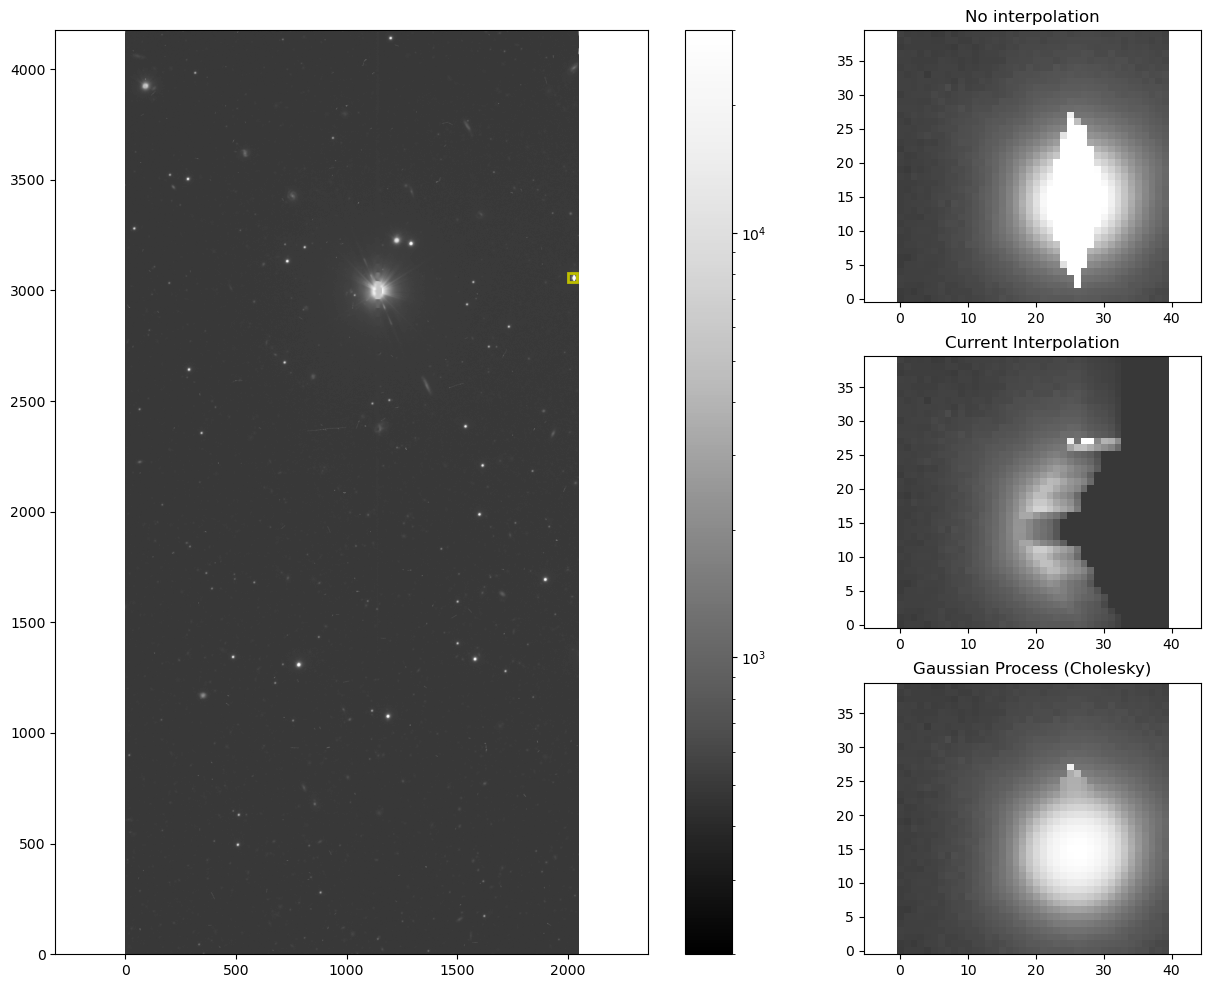

In [7]:
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title="test", artist='Matplotlib', comment="Test")
writer = FFMpegWriter(fps=1, metadata=metadata, bitrate=4000)
Name_mp4 = "test_log.mp4"

index = [307, 308, 2027, 2973, 2974, 2975]

fig, axes = setup_plot()

to_plot_maskedImage = copy.deepcopy(maskedImage)

with writer.saving(fig, Name_mp4, 250):
    for i in tqdm(range(len(indexes))):
        I = indexes[i]
        if i != 0:
            for window in axes:
                window.cla()
            first_time = False
        else:
            first_time = True
        get_plot(to_plot_maskedImage, maskedImage_current_interp, I, dic, fig, axes, first_time=first_time, replace=True)
        writer.grab_frame()

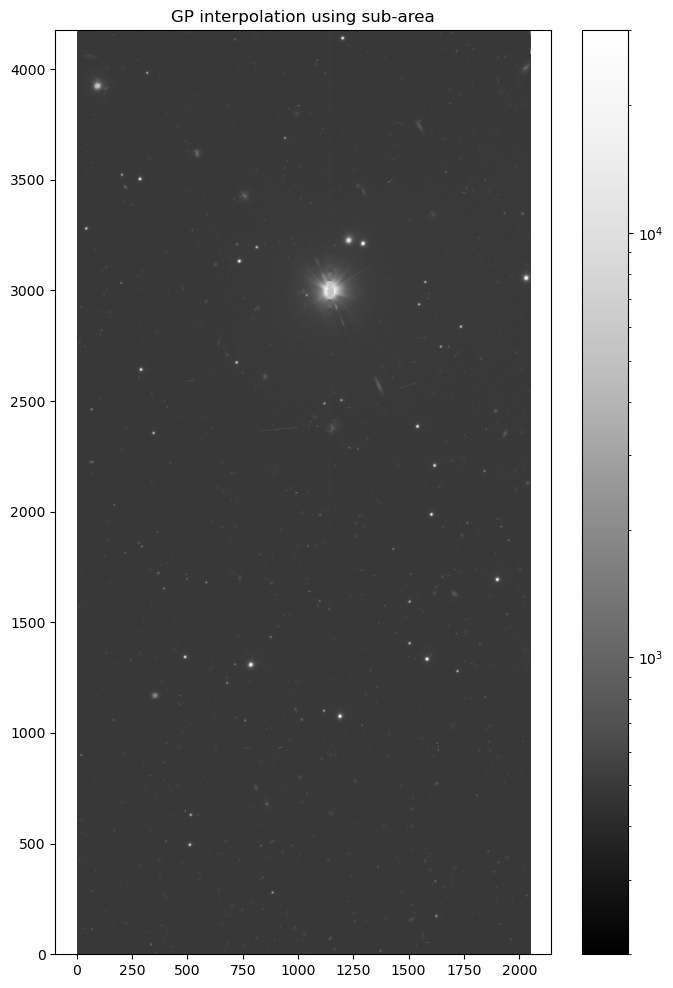

In [17]:
CMAP = plt.cm.Greys_r
kwargs = {'norm': LogNorm(vmin=200, vmax=30000), 'cmap':CMAP}


plt.figure(figsize=(8,12))
plt.imshow(to_plot_maskedImage.getImage().array, **kwargs)
plt.axis('equal')
plt.title('GP interpolation using sub-area')
plt.gca().invert_yaxis()
plt.colorbar()
plt.savefig('1_GP_interpolation.png')

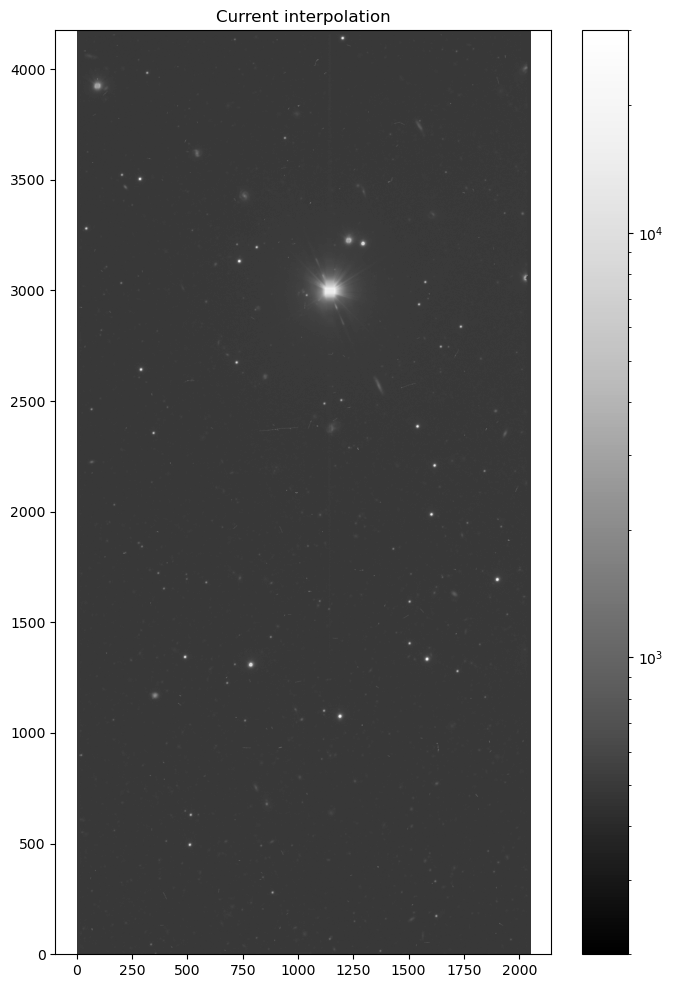

In [16]:
CMAP = plt.cm.Greys_r
kwargs = {'norm': LogNorm(vmin=200, vmax=30000), 'cmap':CMAP}


plt.figure(figsize=(8,12))
plt.imshow(maskedImage_current_interp.getImage().array, **kwargs)
plt.axis('equal')
plt.title('Current interpolation')
plt.gca().invert_yaxis()
plt.colorbar()
plt.savefig('0_current_interpolation.png')